# Title

## Business Overview

### The problem

We were tasked with providing Computing Vision a series of suggestions for their transition into the film industry. Specifically, we aimed to determine suggestions that could target higher levels of revenue and/or profit.

### The goal

The film industry is a creative and diverse market with several avenues to success. With the understanding that there is no one path to success, we aimed to generate insight into a variety of actions Computing Vision may want to take in order to carve their own unique path to success. To accomplish this goal, we analyzed several different facets of films and their relation to generating revenue and profit. These areas included genres, day of release, and experience level of directors. 

## The Datasets

The range of our analyses required utilization of several datasets. For each area of analysis, we used:

Directors:

Release Day:

Genres:
- Movie Budgets dataset from (INSERT SOURCE HERE). Including movie titles, production budget, and worldwide gross revenue. 
- TMDB dataset including movie titles and genres.

## The Methods and Results

# Imports

##  DIMA
### Experience Level of Directors in relation to Profit

***The Business Question***

Does the expertise of the director affect the movie's profitability?

***The Datasets***

In this section, we used the following datasets:

- Movie Info dataset from Rotten Tomatoes which included the Director column required for this analysis.
- Movie Budgets dataset from The-Numbers which included the movie titles, production budget, and worlwide gross which we used to calculate the profit which is our main measure of success in the project

To explore the data we will first start off with importing the necessary libraries needed.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_iris
from pandas import Series, DataFrame

%matplotlib inline

### Movie Info
Starting with the movie info dataframe, the first step is to read into the tsv file

In [ ]:
# Read in the data as movie_info
# Use parse_dates and pass column name to read it as a datetime
movie_info = pd.read_csv('../Data/rt.movie_info.tsv', encoding='latin-1', sep='\t', 
                        parse_dates=['theater_date', 'dvd_date'])
movie_info.head()

#### Data Cleaning
In this section, we will start by cleaning the movie_info dataframe before we can draw any conclusions. It will help us inspect the data better and get a more accurate general understanding of the data at hand.

Step 1: Check if we have any null values in each column

In [ ]:
movie_info.isnull().sum()

Step 2: Dealing with null values

To clean the columns from null values, we will be replacing the null values in the column with generic terms relevant to each column so that it's all consistent across the columns.

In [ ]:
#Fill the missing values in synposis, genre, director, writer, currency, studio with 'Missing'
movie_info['synopsis'].fillna('Missing', inplace=True)
movie_info['rating'].fillna('Missing', inplace=True)
movie_info['genre'].fillna('Missing', inplace=True)
movie_info['director'].fillna('Missing', inplace=True)
movie_info['writer'].fillna('Missing', inplace=True)
movie_info['currency'].fillna('Missing', inplace=True)
movie_info['studio'].fillna('Missing', inplace=True)

In [ ]:
#Fill theater_date and dvd_date missing values with a generic date "1800-01-01" to keep same format
movie_info['theater_date'].fillna('1800-01-01', inplace=True)
movie_info['dvd_date'].fillna('1800-01-01', inplace=True)

In [ ]:
#Fill box_office missing valus with 0
movie_info['box_office'].fillna(0, inplace=True)

In [ ]:
#Fill runtime missing valus with 0
movie_info['runtime'].fillna('0 minutes', inplace=True)

#Change the type of data so that we are able to use it later on if we needed to.
movie_info['runtime'] = movie_info['runtime'].str.replace('minutes',"")
movie_info['runtime'] = pd.to_numeric(movie_info['runtime'])

Step 3: check for any duplicates

In [ ]:
movie_info.duplicated().value_counts()

It doesn't look like we have any duplicates. In this case, we are good to proceed forward.

#### Analysis methods

In this section, We will look into the Director column within this data frame to see if the Director's expertise affects the movie's success.

The question being analyzed is whether the expertise of the director affects the movie's profitability.

We will look at the count of movies directed per director, as directors with more experience could potentially yield higher profit due to their expertise.

- First, we will look at the budgets table.
- Second, we want to look at the trend between the count of movies per director and the profit
    - To do that, we will merge the budget dataframe and movie_info dataframe to check the profit generated by each director.
- Third, we will sort the top directors with the highest average profit.

We will start by reading into the budgets table and cleaning it

In [ ]:
#reading into the csv data file
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
budgets.head()

In this table we will assume that **Revenue** = 'worldwide_gross' & **Cost** = 'production_budget'

In [ ]:
#will follow Morgan's data cleaning for this table
# removing $ and , from gross revenue
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",","")
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$","")

# casting the values as integers
budgets['worldwide_gross'] = pd.to_numeric(budgets['worldwide_gross'])

# removing $ and , from production budget
budgets['production_budget'] = budgets['production_budget'].str.replace(",","")
budgets['production_budget'] = budgets['production_budget'].str.replace("$","")

# casting the values as integers
budgets['production_budget'] = pd.to_numeric(budgets['production_budget'])

In [ ]:
# calculating total profit = revenue - cost
budgets['total_profit'] =  budgets['worldwide_gross'] - budgets['production_budget']

From here on we will be comparing the total profit from the budgets table to the Directors in the movie_info table.

Since we don't need all the columns in the dataframe, we will create a new one with only the columns necessary to the analysis.

In [ ]:
movie_budgets = budgets[['id','movie','worldwide_gross','total_profit']]

### Merging movie_info & budget dataframes

We will join the dataframes using an **inner** join because it returns only the records with matching keys in both tables, we will make a separate dataframe for the joined dataframes.

In [ ]:
movie_info_budget = movie_budgets.join(movie_info, how='inner', lsuffix = '_movie_budgets' , rsuffix = '_movie_info')
#checking the resulting dataframe
movie_info_budget.head()

In [ ]:
#I want to check how many 0 we have for worldwide gross, we can see if the minimum number is 0
movie_info_budget['worldwide_gross'].describe()

To deal with these values, we decided to replace it with the median profit because the median is more resilient against extreme outliers.

In [ ]:
median_gross = movie_info_budget['worldwide_gross'].median()
movie_info_budget['worldwide_gross'] = movie_info_budget['worldwide_gross'].replace(0,median_gross)

We will now start looking if there are any trends between the expertise of the director vs. the profit

In [ ]:
#Create top directors df so that we can visualize top directors and top profit
#The count will show us the count of movies each director has worked on
director_counts = pd.DataFrame(movie_info_budget.groupby('director')['movie'].count())

#We are summing the profit of all the movies per director into the total profit
director_total_profit = pd.DataFrame(movie_info_budget.groupby('director')['total_profit'].sum())

In [ ]:
# I will now join the director counts and total profit together into a new df, I will also sort it by total profit
top_directors = director_counts.join(director_total_profit, how='outer', lsuffix = '_director_counts' , rsuffix = 'director_total_profit')
top_directors = top_directors.sort_values(by='total_profit', ascending=False)

In [ ]:
#Dropping the missing values
top_directors = top_directors.drop(labels="Missing")

In [ ]:
#We will add the average profit per director since it would be more accurate to look at it than Total profit
top_directors['avg_profit'] =  top_directors['total_profit']/top_directors['movie']
top_directors['avg_profit'] = top_directors['avg_profit'].sort_values(ascending=False)
top_directors

Now to visualize the results we will display it using a boxplot to display the spread of the data.

In [ ]:
# We will visualize the results
# Plot average profit vs. count of movies directed 
plt.figure(figsize=(12,8))
sns.boxplot(x = top_directors['movie'], y = top_directors['avg_profit'], palette='crest')
plt.title('Average Profit vs.  Count of Movies per Director', fontsize=16)
plt.xlabel('Count of Movies Directed')
plt.ylabel('Average Profit in Billions')
plt.tight_layout()
plt.show()


The trend that the boxplot reflects is that directors that have directed 3 or more movies have always had an average profit that is positive. We can see that the minimum for 3 movies is always positive. 

The are many outliers for Directors with just one movie, and a few in those with 2 movies, but as we move to directing 3 or more we don't see as many outliers. Therefore, we can conclude that as these Directors worked on more movies, the factor of luck has been eliminated and they've continued to be profitable.

Drawing from this trend, going forward we will look at the top 20 directors in terms of average profit that directed 3 or more movies.

In [ ]:
#Getting the top 20 directors that directed 3 or more movies
three_plus_movies = top_directors[(top_directors['movie'] >= 3)].head(20)
three_plus_movies = three_plus_movies.reset_index()
three_plus_movies

In [ ]:
#now let's visualize the results
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x = three_plus_movies['director'], y = three_plus_movies['avg_profit'], order= three_plus_movies.sort_values('avg_profit',ascending = False).director, palette="crest")
plt.xticks(rotation=60)
plt.xlabel(None)
plt.ylabel('Average Profit in 100 Million')
plt.title('Top 20 Directors with Three or More Movies in terms of Average Profit', fontsize=14)
plt.show();

This barplot displays the top 20 directors in terms of average profit that have directed 3 or more movies. Drawing from this, if Computing Vision has the budget they could potentially hire one of these directors, or they can look into their work and get inspired by it.

#### Conclusion / Suggestion

In the context of this project an experienced director is defined as a director that has directed three or more movies.

Since Computing Vision is a new studio that is just starting in the movie industry, we ***recommend*** that they hire an experienced director that has experience directing three or more movies since our analysis showed that it is likely for these directors to continue being profitable on the 4th movie. 

According to our analysis, experienced directors always resulted in positive average profit. While directors with less than 3 movies can also be profitable, however, going through a risk averse route and eliminating the factor of luck from success, experienced directors have proved to be profitable on the third movie and on.

#### What limitations are there?

One limitation that could be pointed out could be that there is a survival bias in the research, in which survival bias is defined as a type of sampling error or selection bias that occurs when the selection process of a trial favours certain individuals who made it past a certain obstacle or point in time and ignores the individuals who did not. In our case it would be selecting Directors with three or movies, and ignoring the ones with less experience. However, we concluded that for a new studio it is preferable that on their first projects that they take a route that is proven to be successful and taking less risks and that is by hiring an experienced director to direct their movies. 

Another limitation is in the case of trying to recommend to hire one of the top 20 Directors in terms of their average profit and their expertise, a limitation was that some of the top 20 directors are in fact deceased. Deceased Directors: Boris Karloff, Howard Hawks, Anatole Litvak, John Frankenheimer, Charles Walters, Curtis Hanson.

However, in light of this limitation, a business suggestion here would be to look into these directors' work and potentially acquiring the rights to their work if possible and generate profit off of that.

## LEO
### Day of Release as a Predictor of Revenue
### Project Goals, Data, Methods, and Results:
In this notebook you will find my data cleaning, organiztion, and results for the Capstone Project.

In essence we like to keep things as straight forward as possiable. Our goal here is to demostrate that we understand the data and that we are confident in making relevant connections. 

We decided that a simple and very relevant business recommendation is what day of the week a movie should be released. Why is this important? Money, more specifically when it comes to box office sales/revenue. 

When it comes to products, be it a pair of shoes, watch, or in this case a Movie, We want to release these products on the day that yields the most money. 

Therefore, based on this goal we will go through the data and search for the desired day of the week that shows most box office sales. Very simple and straight forward. 

In [ ]:
# starting with significant imports 
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import datetime 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import scipy.stats
import scipy.optimize
import scipy.spatial
from IPython import display
from ipywidgets import interact, widgets

import re
import mailbox
import csv
import seaborn as sns

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

#### Datasets and cleaning

In [ ]:
# Load data
movie_info = pd.read_csv('../data/rt.movie_info.tsv', sep="\t")
movie_info.head(10)

In [ ]:
# Basic info in the data
movie_info.info()

In [ ]:
# making the box office data type a float and getting rid of the commas
movie_info['box_office'] = pd.to_numeric(movie_info['box_office'].str.replace(',', ''))

In [ ]:
# turning the theater_date column into a datetime object
movie_info['theater_date'] = pd.to_datetime(movie_info['theater_date'], format='%b %d, %Y')

In [ ]:
# making sure that the datetime changed
movie_info.head()

In [ ]:
# now we can create another column so that we can refrence what day the movies came out.
# we can simply make a column with these days
movie_info['day_of_week'] = movie_info['theater_date'].dt.day_name()

In [ ]:
# here we want to see the value count for each day.
# this will give us a picture of what days have a high count
movie_info['day_of_week'].value_counts()

In [ ]:
# dropping null values in te box office column
movie_info = movie_info.dropna(subset=['box_office'])

In [ ]:
# making sure the nulls are gone
movie_info['box_office'].isnull().sum()

In [ ]:
# starting a new dataframe with the columns we want to further inspect
new_subset = movie_info[['theater_date', 'box_office', 'day_of_week']]

In [ ]:
# resetting the index
new_subset.reset_index(drop=True, inplace=True)

In [ ]:
# inspecting the null values that i have.
new_subset.isnull().sum()

In [ ]:
# dropping nulls
new_subset = new_subset.dropna(subset=['theater_date'])

In [ ]:
new_subset = new_subset.dropna(subset=['day_of_week'])

In [ ]:
# making a new dataframe with the desired columns for further analysis.
# also sorted them.
final_subset = new_subset[['theater_date', 'box_office', 'day_of_week']]
final_subset.sort_values(['box_office', 'day_of_week'], inplace=True)

In [ ]:
# a way to remove this redundancy is to create a separate table with days data and linking it to the box office using-
# an index. this is called data normalization.
days = final_subset[['day_of_week', 'box_office']].drop_duplicates()
days.info()

In [ ]:
# since the index is unique we need to carry it explicitly as a column.
# we will reset the index and rename it id
days.index.name = 'id'
my_id = days.reset_index()
my_id.head()

In [ ]:
# merging together
pd.merge(my_id, days, on=['day_of_week', 'box_office']).head()

In [ ]:
# heres a simplified table
tidy = pd.merge(my_id, days, on=['day_of_week', 'box_office'])
tidy.sort_values(['box_office', 'day_of_week'], inplace=True)

In [ ]:
box_plot = sns.boxplot(x="day_of_week", y="box_office", data=tidy)

ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=7,
        color='white',
        bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout()

#### Analysis methods
Most of the analysis methods used were filters, and pandas functions. We also used datetime manipulation which made things easier. 

We also used the box plot above to describe our findings. Overall, pretty straight forward. 

#### Conclusion / Suggestion
Based on the findings on box office revenue and day of the week that the movie was released, Friday is the best day to release a movie. Since the majority of the movies come out on Friday, the biggest yield in box office revenue is Friday.

#### Therefore, we can recommend that Computing Vision should relese their movies on Friday to maximize box office revenue

These findings are important because a company like Computing Vision, that is starting off in the movie industry should maximize those box office sales.

#### What limitations are there?
The only limitations we can think of is that the sample size is not big enough. This does not allow for more accurate testing. 

The outliers for Friday were pretty significant as well. Compared to the other days, Friday's box is tight meaning that there is not a lot of varience compared with the other outliers. 

## Genre (Landon)

#### Datasets and cleaning
The datasets used for this analysis were:

    - im.db (from imdb.com - accessed through sqlite3)
    - tn.budgets.csv (from The-Numbers.com)

Within the IMDB dataset, the tables movie_basics, and movie_reviews was called and merged on the primary key, "movie_id". The values in the genre column needed to be split on every comma, as many movies were classified under multiple genres. The entries were split within the column, and then for every genre in the column, a new row was created with the respective genre.

For example, if a *Lord of the Rings* movie was classified as an action *and* adventure film, *Lord of the Rings* would appear in two separate rows. The genre value would be "action" in one row, and "adventure" on the other. The resulting dataframe was trimmed so that it only contained the primary_title and genre column.

Next, the tn.budgets.csv file was loaded in using pandas. The financial columns were in a common monetary format as strings; this was rectified by using the "str.replace()" method, and then casting the columns as numeric. A new "total_profit" column was created by subtracting the production budget from the worldwide gross. This inevitably creates an *estimate* of the total_profit, as it is unknown if the entire budget was utilized. As a result, the total_profit is expected to be *at least* the current value.

To use information that otherwise is not very telling, the two tables were merged with the keys being "primary_title" and "movie".  The merged table would pair the "total_profit" column to each respective movie. After the merge, the resulting dataframe had 6,452 entries (which, as a reminder, is *not* equal to the number of movies).

Bringing back the example from above, *Lord of the Rings* would appear in two separate rows as follows:

    | primary_title      | genre     | total_profit |
    |*Lord of the Rings* | Action    | 340000000    |
    |*Lord of the Rings* | Adventure | 340000000    |

Using this data structure, it was possible to create box plots for each genre and compare them to one another. 

#### Analysis methods

In [ ]:
# Imports
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# establish connection to the database
conn = sqlite3.connect('../data/im.db')

# read in the various tables from the database
tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
tables

In [ ]:
# Look into movie ratings
movie_ratings = pd.read_sql("""
    SELECT *
    FROM movie_ratings""", conn)
movie_ratings

In [ ]:
# Look into movie basics
movie_basics = pd.read_sql("""
    SELECT *
    FROM movie_basics""", conn)
movie_basics

In [ ]:
# Checking to see if any movie id appears more than once
pd.read_sql("""
    SELECT *
    FROM movie_basics
    GROUP BY movie_id
    HAVING COUNT(movie_id) > 1;
""", conn)

In [ ]:
# Connect the two tables
mb_mr = pd.read_sql("""
    SELECT *
    FROM movie_basics as b
    INNER JOIN movie_ratings as r
        ON b.movie_id = r.movie_id;
""", conn)
mb_mr 

In [ ]:
# Will remove duplicate column without damaging indeces
mb_mr = mb_mr.loc[:, ~mb_mr.columns.duplicated()].copy()
mb_mr

In [ ]:
# Split genres and create a new entry for each of the genre a movie falls into
### FROM Leo's EDA notebook
s = mb_mr['genres'].str.split(',').apply(Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'genre'
del mb_mr['genres']
mb_mr_genres = mb_mr.join(s)

In [ ]:
mb_mr_genres = mb_mr_genres[['primary_title', 'genre']]
mb_mr_genres.head(20)

## Load in tn.movie.budgets.csv
### Cleaning

In [ ]:
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
budgets.head()

In [ ]:
# removing $ and , from gross revenue
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(",","")
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace("$","")
budgets['production_budget'] = budgets['production_budget'].str.replace(",","")
budgets['production_budget'] = budgets['production_budget'].str.replace("$","")

# casting the values as integers
budgets['production_budget'] = pd.to_numeric(budgets['production_budget'])
budgets['worldwide_gross'] = pd.to_numeric(budgets['worldwide_gross'])

# calculating total profit
budgets['total_profit'] =  budgets['worldwide_gross'] - budgets['production_budget']

# Keep only movie and total_profit columns
budgets = budgets[['movie', 'total_profit']]

# confirmation
budgets.head()

In [ ]:
# merge mb_mr_genres with budgets table on movie titles
combined = pd.merge(mb_mr_genres, budgets, left_on="primary_title", right_on="movie")
combined.drop(columns="movie", inplace=True)
combined

The duplicate values in the rows are okay to have for what I am going to
accomplish with them. I will create a boxplot where the x is the genre categories, and the y is the total_profit column associated with those genres. Before proceeding to that, I need to clean up the new table and deal with outliers.

## Cleaning + dealing with outliers

In [ ]:
# Getting 25th percentile of genre counts... the max 1491 is drama
combined['genre'].value_counts().describe()

In [ ]:
# remove any genre where the count is lower than 100
mask = combined['genre'].value_counts() > 100

vals_to_keep = []
for x in mask.items():
    if x[1] == True:
        vals_to_keep.append(x[0])
        
vals_to_keep

In [ ]:
# Create table where we've kept rows where the value in genre
# matched the vals_to_keep
combined = combined.loc[combined['genre'].isin(vals_to_keep)]
combined

## Charting
### Dealing with outliers using showfliers=False

In [ ]:
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(figsize = (14,12))
sns.boxplot(ax=ax, x=combined['genre'],
            y=combined['total_profit'],
            showfliers=False)

plt.style.use('seaborn-muted')

# scale y axis to millions
scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(-250000000, 1000000000)

# add title/labels/ticks/grid
ax.set_title('Profit Distribution by Genre (USD)', size=24)
plt.xlabel("Genre", size = 20)
plt.ylabel("Total Profit (in millions)", size=20)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.2)

# create red area in negative y
plt.axhline(y=[-1000000], alpha=0.3, color='red', fillstyle='bottom')
plt.axhspan(-2500000000, 0, alpha=0.15, color='red')

# saves fig
#plt.savefig('../resources/charts/prof_genre_box.png', dpi=fig.dpi)
;

### Narrow down genres

In [ ]:
# look at what genres have the top median profits
med_combined = combined.groupby('genre', sort='total_profit').median()
med_combined = med_combined.sort_values(by='total_profit', ascending=False)
med_combined_8 = med_combined.head(8)
med_combined_8

In [ ]:
# Preparing to keep only the top 8 median genres
vals_to_keep = []
for x in med_combined_8.iterrows():
    vals_to_keep.append(x[0])
        
vals_to_keep

In [ ]:
# Create table where we've kept rows where the value in genre
# matched the vals_to_keep
top_8_combined = combined.loc[combined['genre'].isin(vals_to_keep)]
top_8_combined

## Charting the 8 genres with the highest median profit

In [ ]:
fig, ax = plt.subplots(figsize = (14,12))
sns.boxplot(ax=ax, x=top_8_combined['genre'],
            y=top_8_combined['total_profit'],
            showfliers=False)

plt.style.use('seaborn-muted')

# scale y axis to millions
scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(-250000000, 1000000000)

# title/labels/ticks
ax.set_title('Profit Distribution by Genre (USD)', size=24)
plt.xlabel("Genre", size = 20)
plt.ylabel("Total Profit (in millions)", size=20)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.2)

# adding negative y color
plt.axhline(y=[-1000000], alpha=0.3, color='red', fillstyle='bottom')
plt.axhspan(-250000000, 0, alpha=0.15, color='red')

# save fig
#plt.savefig('../resources/charts/top8_prof_genre_box.png', bbox_inches='tight')
;

## Charting the top 8 WITH outliers

In [ ]:
fig, ax = plt.subplots(figsize = (14,12))
sns.boxplot(ax=ax, x=top_8_combined['genre'],
            y=top_8_combined['total_profit'],
            showfliers=True)

plt.style.use('seaborn-muted')

# scale y axis to millions
scale_y = 1e6
ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_ylim(-250000000, 2250000000)

# title/labels/ticks
ax.set_title('Profit Distribution by Genre (USD)', size=24)
plt.xlabel("Genre", size = 20)
plt.ylabel("Total Profit (in millions)", size=20)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=2, alpha=0.2)

# adding negative y color
plt.axhline(y=[-1000000], alpha=0.3, color='red', fillstyle='bottom')
plt.axhspan(-2500000000, 0, alpha=0.15, color='red')

# saves fig
#plt.savefig('../resources/charts/top8_outlier_prof_genre_box.png', dpi=fig.dpi)
;

Creating a small table with top 8 performing genres that displays their median income

In [ ]:
# rename total profit column to median profit
med_combined_8 = med_combined_8.rename({'total_profit': 'median_profit'},
                                       axis=1)
med_combined_8

#### Conclusion / Suggestion
Based off of the boxplots, two genres stand out based on their median profit: Animation and Adventure. These genres also appear to have the highest variance as they are stretched (or tall, if you will). 

It also appears there is a positive skew, as the distance from the median to the upper quartile is much greater than the distance to the lower quartile. This positive skew means that most movies, within their respective genre, had a positive net income, but some generate extraordinarily higher amounts. It is not to say that genre is an indicator of profit, but just an observation of the current data set.

These findings are merely a surface level analysis, and therefore not conclusive. Going forward, we will utilize statistical methods to dig deeper into our observations.

#### Side Note
Aside from statistical analysis, a next step could be creating a profit to budget ratio. Lower budget films with a consistently higher profit to budget ratio could be an worthwhile investment as a lower-cost entry point as new studio.

## Genre's Association with Profit (Chi Square Analysis)

## The Business Question
Does the genre of a movie have any significant association with the movie's profitability?

## The Datasets
- Movie budgets dataset from the-numbers.com including movie titles, production budget, and worldwide gross revenue with 5,782 rows.
- TheMovieDB dataset including movie titles and genres with 26,517 rows.

## The Methods

### Import and Clean Data

We began with importing all relevant libraries for analysis and visualization. 

In [34]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter, NullFormatter

import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

The relevant datasets for our analysis were the tn.movie_budgets.csv and tmdb.movies.csv files. 

In [35]:
budgets = pd.read_csv("../data/tn.movie_budgets.csv")
tmdb = pd.read_csv("../data/tmdb.movies.csv", index_col = 0)

Before running our analysis, we needed to review the contents of the datasets, isolate relevant columns, and clean data as necessary.

First, we looked at the first few rows of the movie budgets dataframe in order to get an idea of the columns, potential datatypes, and areas which may require pre-processing and cleaning. 

In [36]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


From this dataframe, we decided that we needed to retain the following columns:
- Movie (for joining with other dataframes)
- Production Budget and Worldwide Gross (for calculating profit)

Thus, we formed a subset of the dataset including only the relevant columns.

In [37]:
cols_to_keep = ['movie','production_budget','worldwide_gross']
budgets_relevant = budgets[cols_to_keep]

We also noted that the production budget and worldwide gross columns were populated with strings (as evident by the symbolic characters used alongside the numeric characters, such as "$"). These values needed to be cleaned and cast as integers before they could be used to calculate profit. 

However, before doing any further cleaning we looked for null values and duplicates so that we could avoid making any unnecessary calculations. There were no obvious nulls in the dataframe. However, looking at the values stored within the worldwide_gross column brought to light some null-esque values. Namely, movies with a worldwide gross revenue of $0. There were some zeroes in this column, presumably because there was no available data on its gross revenue. We originally removed these observations from the dataframe. However, we discovered later on that this resulted in a very small sample size when coupled with the unavoidable loss of other observations. So rather than removing these observations, we decided to replace them with the median once the column had been properly cleaned. We decided to use the median rather than the mean for imputation because this was a highly skewed dataset with outliers that would significantly impact the mean, but the median would be more resilient against. 

From here, we moved on to locating duplicate values. There were no obvious duplicate rows. However, we realized that multiple movies could have the same title. This would pose an issue when we needed to join dataframes using movie titles as the mutual column. 

In [38]:
def get_title_counts(data, col):
    
    '''
    Inputs: Dataframe and movie title column
    Outputs: Dataframe of movie titles which appear in the dataset more than once
    
    '''
    
    # set the value counts as a dataframe
    title_counts = pd.DataFrame(data[col].value_counts())
    
    # reset index so that we can easily access the titles
    title_counts = title_counts.reset_index()
    
    # take a subset of the title counts dataframe for all titles that appear more than once
    title_counts = title_counts.loc[ title_counts[col] > 1 ]
                                    
    # return this dataframe of title duplicates                                
    return title_counts

title_counts = get_title_counts(budgets_relevant, 'movie')
print(f"Number of repeated titles: {len(title_counts)}")

Number of repeated titles: 81


There were 81 movies with repeated titles in the dataframe. 81 rows out of a 5,000+ row dataset didn't seem substantial enough to justify the attempted mutli-column merge. So, we decided to simply drop the duplicates.

In [39]:
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

def remove_duplicate_titles(data, col):
    
    '''
    Inputs: Dataframe and movie title column
    Outputs: The same dataframe without movies that appear more than once. 
    
    '''
    
    # get the dataframe for titles which appear more than once
    title_counts = get_title_counts(data,col)
    
    # create a dichotomous column for which there is a 1 if the movie is a duplicate title
    data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)
    
    # take a subset of the dataframe of only non-duplicate titles
    data = data.loc[ data['duplicate'] == 0]
    
    # initialize a list of columns to maintain
    keepers = []
    
    # for each column in the dataframe
    for col in data.columns:
        # if it isn't the duplicate column
        if col != "duplicate":
            # add it to the list of columns to be maintained
            keepers.append(col)
    
    # keep only the columns intended
    data = data[keepers]
        
    return data

budgets_relevant = remove_duplicate_titles(budgets_relevant, 'movie')

<ipython-input-39-aca4b65cdd55>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duplicate'] = data[col].map(lambda x: 1 if any([movie in x for movie in list(title_counts['index'])]) else 0)


After checking for nulls and duplicates, we cleaned the budget and gross revenue columns so that we could eventually use them to calculate profit. 

In [40]:
def dollar_to_numeric(column):
    
    '''
    Inputs: Column containing USD strings
    Outputs: The contents of the column as integers
    
    '''
    # removing $ and , from string
    column = column.str.replace(",","")
    column = column.str.replace("$","")

    # casting the values as integers
    column = pd.to_numeric(column)
    
    return column

budgets_relevant['worldwide_gross'] = dollar_to_numeric(budgets_relevant['worldwide_gross'])
budgets_relevant['production_budget'] = dollar_to_numeric(budgets_relevant['production_budget'])


After successfully casting the data as integers, we replaced all zeroes in the worldwide_gross column with the median worldwide gross revenue. 

In [41]:
median_gross = budgets_relevant['worldwide_gross'].median()
budgets_relevant['worldwide_gross'] = budgets_relevant['worldwide_gross'].replace(0,median_gross)

Now that we had two clean revenue and cost columns to work with, we used this information to create a new column in the dataframe for the calculated profit. 

In [42]:
# calculating total profit
budgets_relevant['total_profit'] =  budgets_relevant['worldwide_gross'] - budgets_relevant['production_budget']

budgets_relevant = budgets_relevant[['movie','total_profit']]

Next, we decided to visualize the distribution of profit since this is our dependent variable.

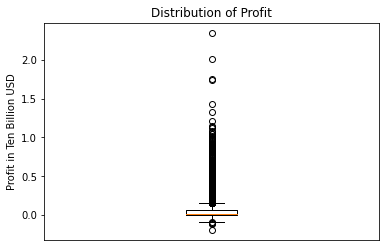

In [43]:
fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Ten Billion USD")
plt.xticks([])
ax.yaxis.get_offset_text().set_visible(False);

It was evident that there were some extremely profitable (and extremely unprofitable) movies that may influence the results of our analysis. Because of the presense of extremes, we decided to remove any movies with profits outside of the interquartile range.

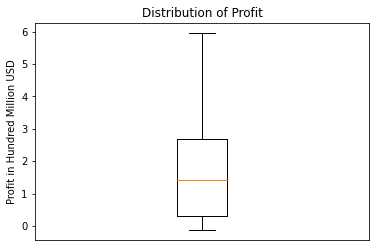

In [44]:
# find Q1, Q3, and interquartile range for each column
Q1 = budgets_relevant['total_profit'].quantile(q=.25)
Q3 = budgets_relevant['total_profit'].quantile(q=.75)
IQR = budgets_relevant['total_profit'].apply(stats.iqr)

budgets_relevant = budgets_relevant.loc[~((budgets_relevant['total_profit'] < (Q1-1.5*IQR)) | (budgets_relevant['total_profit'] > (Q3+1.5*IQR)))]

fig, ax = plt.subplots()
ax.boxplot(budgets_relevant['total_profit'])
ax.set_title("Distribution of Profit")
ax.set_ylabel("Profit in Hundred Million USD")
plt.xticks([])
ax.yaxis.get_offset_text().set_visible(False);

Knowing that we would eventually have to merge this dataframe with the TMDB dataframe, we also set the index to the column on which we wanted to merge (the movie title). 

In [45]:
budgets_relevant.set_index('movie', inplace = True)

With this dataframe cleaned, we moved on to the TMDB dataframe.

Just like the first dataframe, we began by looking at the first few rows to get an idea of the columns, datatypes, and areas which may require preprocessing/cleaning. 

In [46]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


From this dataframe, we noted that we only needed the following columns:
- Title (for merging)
- Genre_ids

We started with dropping the irrelevant columns.

In [47]:
cols_to_keep = ['title','genre_ids']
tmdb_relevant = tmdb[cols_to_keep]

We noted that the genre_ids column appeared to contain lists of multiple ids associated with specific genres. We needed to clean this column and replace these numbers with their associated genre. However, we decided to wait to replace these values until after the dummy columns were created because it would be easier to rename a small number of columns than replace multiple numbers in every cell with its associated genre. 

So for now, we moved on to locating null values and duplicates. There didn't appear to be any null values in the dataset. However, there were 1088 duplicates which we dropped. There were also duplicate titles in this dataframe which we handled the same as those in the budgets dataframe.

In [48]:
# Drop duplicates
tmdb_relevant = tmdb_relevant.drop_duplicates()
tmdb_relevant = remove_duplicate_titles(tmdb_relevant,'title')

After dropping these duplicate values, we set the movie titles as in the index in preparation for merging these two dataframes. The final dataframe contained 17,714 rows. 

In [49]:
tmdb_relevant = tmdb_relevant.set_index('title')

Now that we had cleaned the data, it was ready to be merged.

In [50]:
budgets_and_tmdb = budgets_relevant.join(tmdb_relevant, how='inner')

After merging the dataframes, we were left with a much smaller dataframe than either of the parent datasets. This, however, was expected given there was no gaurantee that the datasets would overlap in their contents significantly nor was there a gaurantee that there would not be any spelling errors in the titles that would prevent a successful join for at least some rows. We decided to proceed with the knowledge that 656 movies retained the potential to provide some useful insights.

Next, we cleaned the genre id column and isolated each genre id, using the results to create dummy columns. 

In [51]:
def create_dummy_cols(data, col):
    
    '''
    Inputs: Dataframe and column where the column contains a list of genre ids
    Outputs: The same dataframe with dummy columns for each genre id, renamed to reflect the genre
    '''
    
    # remove [, ], and whitespace
    data[col] = data[col].str.strip("]")
    data[col] = data[col].str.strip("[")
    data[col] = data[col].str.replace(" ", "")
    
    # split genre ids by commas
    genre_ids = data[col].str.split(",")
    
    # create the binary dummy columns
    bin_genre_df = pd.get_dummies(genre_ids.apply(pd.Series).stack()).sum(level=0)
    budgets_and_genre_dummys = data.join(bin_genre_df, how='inner')
    
    # rename columns for genres
    budgets_and_genre_dummys.rename(columns = {'28' : 'Action', 
                                           '12' : 'Adventure',
                                          '16' : 'Animation',
                                          '35' : 'Comedy',
                                          '80' : 'Crime',
                                          '99' : 'Documentary',
                                          '18' : 'Drama',
                                          '10751' : 'Family',
                                          '14' : 'Fantasy',
                                          '36' : 'History',
                                          '27' : 'Horror',
                                          '10402' : 'Music',
                                          '9648' : 'Mystery',
                                          '10749' : 'Romance',
                                          '878' : 'SciFi',
                                          '10770' : 'TV',
                                          '53' : 'Thriller',
                                          '10752' : 'War',
                                          '37' : 'Western'}, inplace = True)
    return budgets_and_genre_dummys

budgets_and_genre_dummys = create_dummy_cols(budgets_and_tmdb,'genre_ids')
budgets_and_genre_dummys.head()

,total_profit,genre_ids,,Music,Romance,Family,War,TV,Adventure,Fantasy,...,Horror,Action,Comedy,History,Western,Thriller,Crime,SciFi,Mystery,Documentary
John Carter,7778100,"28,12,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
Green Lantern,19535492,"12,28,53,878",0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0
Jack the Giant Slayer,2687603,"28,12,10751,14",0,0,0,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
Hugo,47784,"12,18,10751",0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Valerian and the City of a Thousand Planets,35098356,"12,878,28",0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


There was a dummy column seemingly associated with no genre. This appeared to be the result of 11 titles which did not have any associated genre ids. So, we dropped them from analysis.

In [52]:
budgets_and_genre_dummys = budgets_and_genre_dummys.loc[ (budgets_and_genre_dummys[''] != 1) ] 

### Chi-Square Analysis

We decided to turn profit into a categorical variable denoting high vs. medium vs. low profit so that we could perform our chi-square analysis (which required that both variables of interest be categorical). The threshold values for these categories were decided as:

- High profit = Profit at the 75th percentile and greater
- Medium = Profit greater than 25th percentile and lower than 75th percentile.
- Low = Profit at the 25th percentile and lower

In [53]:
# define thresholds
iqr_Q1 = budgets_and_genre_dummys['total_profit'].quantile(q=.25)
iqr_Q3 = budgets_and_genre_dummys['total_profit'].quantile(q=.75)

# assign categories based on thresholds
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] >= iqr_Q3, 'relative_profit_cat'] = 'high'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['total_profit'] <= iqr_Q1, 'relative_profit_cat'] = 'low'
budgets_and_genre_dummys.loc[ budgets_and_genre_dummys['relative_profit_cat'].isna() , 'relative_profit_cat'] = 'medium'

From here, we built a contingency table with genres as rows and relative profit category as columns.

In [54]:
##### CREATING CONTINGENCY TABLE

# initialize list of genres
genres = []

# for each column in the dataset
for column in budgets_and_genre_dummys.columns:
    # if it isn't a non-genre column
    ignored_cols = ['total_profit','title','relative_profit_cat','genre_ids','']  
    if column not in ignored_cols:
        # add it to the list of genres
        genres.append(column)
        
## Creating the contingency table

# create a dataframe with profit as columns and genres as rows
contingency_table = pd.DataFrame(columns = ['high', 'medium','low'], index = genres)

# replace the index (this is useful for using the numeric index to populate the dataframe in the next cell)
contingency_table.reset_index(inplace = True)

# fill the table with zeroes
contingency_table = contingency_table.fillna(0)

##### POPULATING CONTINGENCY TABLE

# for each row
for index, row in budgets_and_genre_dummys.iterrows():
    
    # for each column in that row that is a genre
    for col in budgets_and_genre_dummys.columns:
        
        if col not in ignored_cols:
    
            # if the cell value is 1
            if row[col] == 1 :
                
                # find the index associated with that genre in the contingency table
                genre_idx = contingency_table[contingency_table['index'] == col].index.values
                
                # look at the profit category column and save that value as well
                profit_cat = row['relative_profit_cat']
    
                # find the cell associated with that row index and profit column in the contingency table and add 1 
                contingency_table.loc[genre_idx, profit_cat] += 1   

We noted that there were some very small cell sizes. To avoid drawing conclusions based on small sample sizes, we decided to filter out rows in the contingency table with row totals less than 50. Then, we visualized the contingency table proportions.

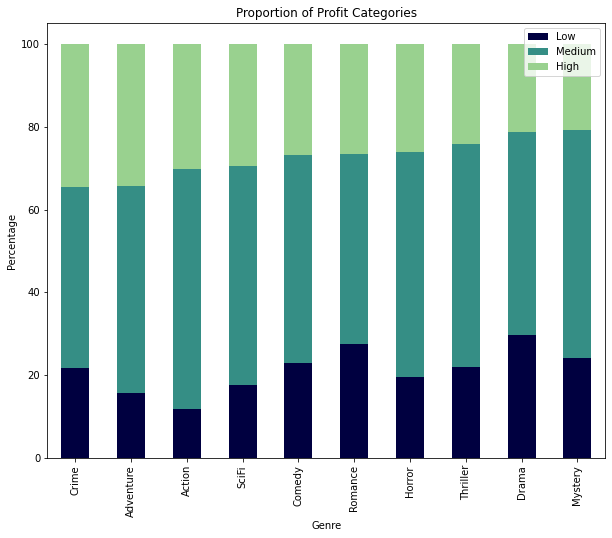

In [55]:
# filter contingency table for low cell sizes
contingency_table = contingency_table.loc[contingency_table['high'] + contingency_table['medium'] + contingency_table['low'] >= 50]
contingency_table = contingency_table.set_index('index')

# save copy of this contingency table for future use
contingency_table_freq = contingency_table.copy()

# Create percentange columns
contingency_table['perc_low'] = round( (contingency_table['low'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)

contingency_table['perc_medium'] = round( (contingency_table['medium'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)

contingency_table['perc_high'] = round( (contingency_table['high'] / 
                                        (contingency_table['low'] + 
                                         contingency_table['medium'] + 
                                         contingency_table['high']))*100,2)

# Create new dataframe which only contains the percentage columns
# sort by greatest proportion of hight profit movies to lowest proportion
contingency_table_prop = contingency_table[['perc_low','perc_medium','perc_high']]
contingency_table_prop = contingency_table_prop.sort_values(by = 'perc_high', ascending = False)

# plot the percentage dataframe
ax = contingency_table_prop.plot(kind = 'bar', stacked = True, 
                           title = "Proportion of Profit Categories", 
                           figsize = (10,8),
                           color = ['#000040', '#358e85', '#99d18f'])
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage")
ax.legend(['Low','Medium', 'High']);

With the contingency table populated and filtered for decent sample size, we were ready to conduct the chi-square test.

In [56]:
from scipy.stats import chi2_contingency

# H_0 : Genre and Profit Level are not associated
# H_1: Genre and Profit Level are associated

stat, p, dof, expected = chi2_contingency(contingency_table_freq)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Reject H_0')
else:
    print('Retain H_0')

p value is 0.04456193254973362
Reject H_0


The low p-value indicated to us that there was a significant association between these genres and relative profit categories. To measure the strength of this association, we calculated the Cramer's V value. 

In [63]:
# Getting relevant values to calculate Cramer's V

# Sample size
n = contingency_table_freq['low'].sum() + contingency_table_freq['medium'].sum() + contingency_table_freq['high'].sum()

# Number of rows
r = len(contingency_table_freq)

# Number of columns
c = 3

cramer = np.sqrt((stat/n) / min(c-1,r-1))

print("Cramer's V: {}".format(round(cramer,2)))

Cramer's V: 0.09


The Cramer's V value ranges from 0 to 1 (not associated to perfectly associated), and our Cramer's V was 0.09. A result this small is indicative of a weak relationship between genre and these profit categories.

So while our results remain statistically significant, the overall strength of their association is weak. To support an understanding of the weakness of this association, we created a series of boxplots to demonstrate profit by genre. The plot retains the order of highest to lowest proportion of low profits.

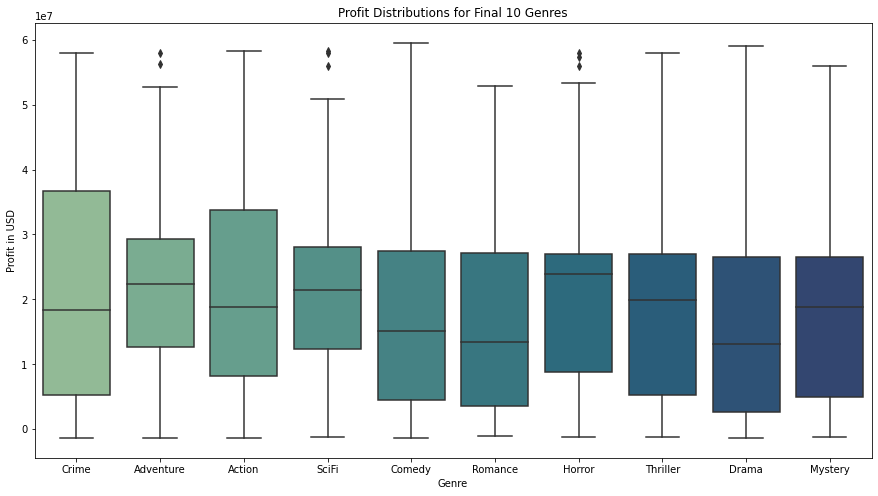

In [65]:
# Creating separate dataframes for each genre
romances = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Romance'] == 1)] 
adventures = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Adventure'] == 1)]
dramas = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Drama'] == 1)]
horrors = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Horror'] == 1)]
actions = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Action'] == 1)]
comedies = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Comedy'] == 1)]
thrillers = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Thriller'] == 1)] 
crimes = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Crime'] == 1)]
scifis = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['SciFi'] == 1)] 
mysteries = budgets_and_genre_dummys.loc[(budgets_and_genre_dummys['Mystery'] == 1)]


# Creating one dataframe for each genre and their profits
combined_dfs = pd.DataFrame({'Romance': romances['total_profit'],
                             'Adventure': adventures['total_profit'],
                             'Drama': dramas['total_profit'],
                             'Horror': horrors['total_profit'],
                             'Action': actions['total_profit'],
                             'Comedy': comedies['total_profit'],
                             'Thriller': thrillers['total_profit'],
                             'Crime': crimes['total_profit'],
                             'SciFi': scifis['total_profit'],
                             'Mystery': mysteries['total_profit']})

# Creating a list of genres in order of greatest to lowest proportion of low profit movies 
# Creating this list so that visualizations can match the order of the most recent contingency table
genre_order = []
for idx, row in contingency_table_prop.iterrows():
    genre_order.append(idx)
genre_order

### Visualizing Profit distributions

import seaborn as sns

fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data=combined_dfs, palette='crest', order = genre_order)
ax.set_title("Profit Distributions for Final 10 Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Profit in USD");
plt.show()

This visualization demonstrates how the profit distributions are relatively similar for each genre with little variation. So, there was not enough evidence of a strong association between these two variables for us to conclude that genre is a reliable tool for profit security. 

## Business Recommendation: Avoid seeking profit security via genre.

Our original business question asked: Does the genre of a movie have any association with the movie's profitability? From our analysis, we can now answer that the relationship between genre and profit is extremely weak. Because of this, our recommendation is to avoid seeking profit by restricting film production to a specific genre, as there is no evidence of a strong association between these two variables. Instead, we suggest additional research into potential confounding factors that  may target the aforementioned higher median profits in animation, adventure, science fiction, action, and fantasy movies. 

## Limitations

Our results do not come without limitations. For example, while we did our best to ensure that the two tables were joined accurately, there exists the possibility that there could be a movie on one dataset with a title shared by an entirely different movie on the other dataset. Future research using data from one resource rather than multiple may help circumvent this issue and provide additional insight. 

There was also the limitation of a relatively small sample size given the original sizes of our raw data. Unfortunately, a lot of movies had to be removed from the dataset during cleaning in order to optimize the accuracy of our output. However, similar studies with larger sample sizes would be beneficial in confirming the results of this analysis. 

Finally, we imputed some values in our dataset to preserve a decent sample size. However, this does introduce potential inaccuracy in our results. Future research with more valid data could provide additional insight.